In [3]:
import io
import zipfile

import numpy as np

x = np.load("maze_dataset/tokenization/MazeTokenizerModular_hashes.npz")["hashes"]
print(x.dtype)

int64


In [ ]:
import itertools
import os
import time

import numpy as np
import tqdm


def to_delta(arr: np.ndarray, name_prefix: str = "") -> dict[str, np.ndarray]:
	original_shape: tuple[int, ...] = arr.shape
	flat_arr: np.ndarray = arr.ravel()

	if flat_arr.size == 0:
		raise ValueError("Cannot delta-encode an empty array!")

	first_val = flat_arr[0]
	deltas: np.ndarray = np.diff(flat_arr)

	return {
		f"{name_prefix}_shape": np.array(original_shape, dtype=np.uint32),
		f"{name_prefix}_first": np.array(first_val, dtype=arr.dtype),
		f"{name_prefix}_deltas": deltas,
	}


def from_delta(d: dict[str, np.ndarray], name_prefix: str = "") -> np.ndarray:
	shape_arr: np.ndarray = d[f"{name_prefix}_shape"]
	original_shape: tuple[int, ...] = tuple(int(s) for s in shape_arr)
	first_val: np.generic = d[f"{name_prefix}_first"]
	deltas: np.ndarray = d[f"{name_prefix}_deltas"]

	total_elements: int = int(np.prod(original_shape))
	flat_arr: np.ndarray = np.empty(total_elements, dtype=first_val.dtype)
	flat_arr[0] = first_val
	flat_arr[1:] = first_val + np.cumsum(deltas, dtype=first_val.dtype)
	return flat_arr.reshape(original_shape)


def measure_compression_methods(x: np.ndarray) -> None:
	"""Measure compression times, sizes, write/read times, and validate the read data.

	This function saves the numpy array `x` into an in-memory npy bytes object.
	It then loops over a set of compression methods (DEFLATED, BZIP2, LZMA) and for each
	compression level from 0 through 9, times the creation (write time) of the archive,
	writes the file to 'tests/_temp/hashes_data/' with an appropriate filename,
	then times the reading back of the array and checks that the loaded array equals the original.

	# Parameters:
	 - `x : np.ndarray`
	    The numpy array to compress.

	# Returns:
	 - `None`
	"""
	# Pre-save the array to a bytes buffer (to avoid timing np.save repeatedly).
	buffer: io.BytesIO = io.BytesIO()
	np.save(buffer, x)
	array_bytes: bytes = buffer.getvalue()

	# Create directory for storing output files.
	output_dir: str = "tests/_temp/hashes_data"
	os.makedirs(output_dir, exist_ok=True)

	# Define the compression methods to test (skipping STORED).
	compression_methods: dict[str, int] = {
		"DEFLATED": zipfile.ZIP_DEFLATED,
		"BZIP2": zipfile.ZIP_BZIP2,
		"LZMA": zipfile.ZIP_LZMA,
	}
	compresslevels: list[int] = [0, 1, 9]

	results: list[tuple[str, int, int, float, float]] = []
	total_iter: int = len(compression_methods) * len(compresslevels)

	# Create a progress bar over all (method, level) combinations.
	progress_bar = tqdm.tqdm(
		itertools.product(compression_methods.items(), compresslevels),
		total=total_iter,
		desc="Compressing",
		unit="combination",
	)

	for (method_name, method), compresslevel in progress_bar:
		# Build a filename based on the method and compression level.
		file_path: str = os.path.join(output_dir, f"{method_name}_{compresslevel}.npz")
		try:
			# Measure write time.
			start_time: float = time.perf_counter()
			with open(file_path, "wb") as f:
				with zipfile.ZipFile(
					f,
					"w",
					compression=method,
					compresslevel=compresslevel,
				) as zf:
					# Use zf.open() to write data so the writing handle is properly closed.
					with zf.open("arr_0.npy", "w") as dest:
						dest.write(array_bytes)
			write_elapsed: float = time.perf_counter() - start_time

			# Get the file size.
			size: int = os.path.getsize(file_path)

			# Measure read time and check that the array matches.
			start_read: float = time.perf_counter()
			with np.load(file_path) as data:
				arr_read: np.ndarray = data["arr_0"]
			read_elapsed: float = time.perf_counter() - start_read

			# Validate that the read array matches the original.
			if not np.array_equal(x, arr_read):
				raise ValueError("Read array does not match the original!")

			results.append(
				(method_name, compresslevel, size, write_elapsed, read_elapsed)
			)
		except Exception as e:
			results.append((method_name, compresslevel, -1, float("nan"), float("nan")))
			print(f"Error for {method_name} level {compresslevel}: {e}")
		progress_bar.set_description(f"{method_name} level {compresslevel}")

	# Print a table of the results.
	header: str = f"{'Method':<10} {'Level':<10} {'Size (bytes)':<15} {'Write Time (s)':<15} {'Read Time (s)':<15}"
	print(header)
	print("-" * len(header))
	for method_name, level, size, write_t, read_t in results:
		print(
			f"{method_name:<10} {level:<10} {size:<15} {write_t:<15.6f} {read_t:<15.6f}"
		)


measure_compression_methods(x)

BZIP2 level 0:  33%|███▎      | 6/18 [00:07<00:16,  1.41s/combination]   Exception ignored in: <function ZipFile.__del__ at 0x7ae75a4b99e0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1940, in __del__
    self.close()
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Error for BZIP2 level 0: Can't close the ZIP file while there is an open writing handle on it. Close the writing handle before closing the zip.


LZMA level 9: 100%|██████████| 18/18 [02:33<00:00,  8.51s/combination] 

Method     Level      Size (bytes)    Write Time (s)  Read Time (s)  
---------------------------------------------------------------------
DEFLATED   0          47033087        0.094867        0.030538       
DEFLATED   1          37215275        1.083005        0.205096       
DEFLATED   2          37216743        1.066938        0.207263       
DEFLATED   3          37217809        1.213259        0.210223       
DEFLATED   6          37210030        1.351686        0.220119       
DEFLATED   9          37210030        1.342759        0.210128       
BZIP2      0          -1              nan             nan            
BZIP2      1          43810539        3.925779        1.892829       
BZIP2      2          44438274        3.776436        1.923420       
BZIP2      3          44821358        3.633637        1.929202       
BZIP2      6          45476720        3.693212        2.206997       
BZIP2      9          45821259        3.813405        2.167051       
LZMA       0        

In [4]:
from pathlib import Path

import numpy as np


def to_delta(arr: np.ndarray, name_prefix: str = "") -> dict[str, np.ndarray]:
	original_shape: tuple[int, ...] = arr.shape
	flat_arr: np.ndarray = arr.ravel()

	if flat_arr.size == 0:
		raise ValueError("Cannot delta-encode an empty array!")

	first_val = flat_arr[0]
	deltas: np.ndarray = np.diff(flat_arr)

	return {
		f"{name_prefix}_shape": np.array(original_shape, dtype=np.uint32),
		f"{name_prefix}_first": np.array(first_val, dtype=arr.dtype),
		f"{name_prefix}_deltas": deltas,
	}


def from_delta(d: dict[str, np.ndarray], name_prefix: str = "") -> np.ndarray:
	shape_arr: np.ndarray = d[f"{name_prefix}_shape"]
	original_shape: tuple[int, ...] = tuple(int(s) for s in shape_arr)
	first_val: np.generic = d[f"{name_prefix}_first"]
	deltas: np.ndarray = d[f"{name_prefix}_deltas"]

	total_elements: int = int(np.prod(original_shape))
	flat_arr: np.ndarray = np.empty(total_elements, dtype=first_val.dtype)
	flat_arr[0] = first_val
	flat_arr[1:] = first_val + np.cumsum(deltas, dtype=first_val.dtype)
	return flat_arr.reshape(original_shape)


start_time: float = time.perf_counter()
np.savez_compressed("tests/_temp/hashes_data/hashes_delta.npz", x)
end_time: float = time.perf_counter() - start_time
file_size: int = Path("tests/_temp/hashes_data/hashes_delta.npz").stat().st_size
print(f"Time to write: {end_time:.6f} seconds")
print(f"File size: {file_size} bytes")

start_time_delta: float = time.perf_counter()
delta_dict = to_delta(x, "hashes")
np.savez_compressed("tests/_temp/hashes_data/hashes_delta_manual.npz", **delta_dict)
end_time_delta: float = time.perf_counter() - start_time_delta
file_size_delta: int = (
	Path("tests/_temp/hashes_data/hashes_delta_manual.npz").stat().st_size
)
print(f"Time to write delta: {end_time_delta:.6f} seconds")
print(f"File size delta: {file_size_delta} bytes")

Time to write: 1.332573 seconds
File size: 37210050 bytes
Time to write delta: 4.266618 seconds
File size delta: 35890401 bytes


In [8]:
np.log2(max(delta_dict["hashes_deltas"]))
min(delta_dict["hashes_deltas"]), max(delta_dict["hashes_deltas"])

(np.int64(94045), np.int64(6529083491397))

In [ ]:
def measure_compression_methods(x: np.ndarray) -> None:
	"""Measure compression times, file sizes, write/read times, and validate the data.

	Iterates over all combinations of:
	- Using delta encoding (True or False)
	- Compression method (DEFLATED, BZIP2, LZMA)
	- Compression level (0, 1, 9)

	The table printed at the end includes a column indicating whether delta encoding was applied.

	# Parameters:
	- `x : np.ndarray`
		The numpy array to compress.

	# Returns:
	- `None`
	"""
	# Define compression methods and levels.
	compression_methods: dict[str, int] = {
		"DEFLATED": zipfile.ZIP_DEFLATED,
		# "BZIP2":   zipfile.ZIP_BZIP2,
		# "LZMA":    zipfile.ZIP_LZMA,
	}
	compresslevels: list[int] = [0, 1, 9]

	# Create combinations: (use_delta, (method_name, method), compresslevel)
	combinations = list(
		itertools.product([False, True], compression_methods.items(), compresslevels)
	)
	progress_bar = tqdm.tqdm(
		combinations, total=len(combinations), desc="Compressing", unit="combination"
	)

	results: list[tuple[str, str, int, int, float, float]] = []
	output_dir: Path = Path("tests/_temp/hashes_data")
	output_dir.mkdir(parents=True, exist_ok=True)

	for use_delta, (method_name, method), compresslevel in progress_bar:
		# Build the filename including the delta flag.
		file_name: str = (
			f"{'delta' if use_delta else 'raw'}_{method_name}_{compresslevel}.npz"
		)
		file_path: Path = output_dir / file_name

		try:
			# Write file.
			start_time: float = time.perf_counter()
			# with open(file_path, "wb") as f:
			# 	with zipfile.ZipFile(
			# 		f,
			# 		"w",
			# 		compression=method,
			# 		compresslevel=compresslevel,
			# 	) as zf:
			# 		with zf.open("arr_0.npy", "w") as dest:
			# 			dest.write(array_bytes)
			np.savez_compressed(
				x if not use_delta else to_delta(x),
				file_path,
				allow_pickle=False,
				compression=method,
			)
			write_elapsed: float = time.perf_counter() - start_time

			# Get file size.
			size: int = os.path.getsize(file_path)

			# Read file.
			start_read: float = time.perf_counter()
			with np.load(file_path) as data:
				if use_delta:
					arr_read: np.ndarray = from_delta(data)
				else:
					arr_read: np.ndarray = data["arr_0"]
			read_elapsed: float = time.perf_counter() - start_read

			# Validate.
			if not np.array_equal(x, arr_read):
				raise ValueError("Read array does not match the original!")

			results.append(
				(
					"delta" if use_delta else "raw",
					method_name,
					compresslevel,
					size,
					write_elapsed,
					read_elapsed,
				)
			)
		except Exception as e:
			results.append(
				(
					"delta" if use_delta else "raw",
					method_name,
					compresslevel,
					-1,
					float("nan"),
					float("nan"),
				)
			)
			print(
				f"Error for {method_name} level {compresslevel} (delta={use_delta}): {e}"
			)

		progress_bar.set_description(
			f"{method_name} level {compresslevel} delta={'Yes' if use_delta else 'No'}"
		)

	# Print the results table.
	header: str = f"{'Delta':<10} {'Method':<10} {'Level':<10} {'Size (bytes)':<15} {'Write Time (s)':<15} {'Read Time (s)':<15}"
	print(header)
	print("-" * len(header))
	for delta_flag, method_name, level, size, write_t, read_t in results:
		print(
			f"{delta_flag:<10} {method_name:<10} {level:<10} {size:<15} {write_t:<15.6f} {read_t:<15.6f}"
		)


measure_compression_methods(x)

In [32]:
import struct
from typing import List, Tuple

import numpy as np

# --- Variable-Length Integer Encoding Utilities ---


def encode_varint(n: int) -> bytes:
	"""Encode an integer using a variable-length encoding scheme.

	# Parameters:
	 - `n : int`
	   The unsigned integer to encode.

	# Returns:
	 - `bytes`
	   The variable-length encoded byte sequence.
	"""
	result: bytearray = bytearray()
	while True:
		byte: int = n & 0x7F
		n >>= 7
		if n:
			result.append(byte | 0x80)
		else:
			result.append(byte)
			break
	return bytes(result)


def decode_varint(data: bytes, offset: int) -> Tuple[int, int]:
	"""Decode a variable-length encoded integer starting at the given offset.

	# Parameters:
	 - `data : bytes`
	   The byte stream containing the encoded integer.
	 - `offset : int`
	   The starting offset in the data.

	# Returns:
	 - `Tuple[int, int]`
	   A tuple (decoded integer, new offset).
	"""
	shift: int = 0
	result: int = 0
	while True:
		if offset >= len(data):
			raise ValueError("Unexpected end of data during varint decoding")
		byte: int = data[offset]
		offset += 1
		result |= (byte & 0x7F) << shift
		if not (byte & 0x80):
			break
		shift += 7
	return result, offset


# --- Custom Compression/Decompression for Sorted 1D int64 Arrays ---


def custom_compress_int64_sorted(x: np.ndarray) -> bytes:
	"""Compress a sorted 1D int64 numpy array using global delta encoding and varint encoding.

	The compressor writes the first element as an 8-byte little-endian integer,
	then for each subsequent element writes the (nonnegative) difference from its predecessor as a varint.

	# Parameters:
	 - `x : np.ndarray`
	   A sorted 1D numpy array of type int64.

	# Returns:
	 - `bytes`
	   The compressed byte stream.

	# Raises:
	 - `ValueError` if the input array is not a 1D int64 numpy array.
	"""
	if x.ndim != 1 or x.dtype != np.int64:
		raise ValueError("Input array must be a 1D int64 numpy array")

	out_bytes: bytearray = bytearray()
	# Write the first element in full (8 bytes, little-endian)
	first: int = int(x[0])
	out_bytes.extend(struct.pack("<q", first))
	# For each subsequent element, encode the difference.
	for i in range(1, x.size):
		diff: int = int(x[i]) - int(x[i - 1])
		# Since the array is sorted, diff is nonnegative.
		out_bytes.extend(encode_varint(diff))
	return bytes(out_bytes)


def custom_decompress_int64_sorted(data: bytes, num_elements: int) -> np.ndarray:
	"""Decompress a byte stream produced by custom_compress_int64_sorted back into a sorted 1D int64 array.

	# Parameters:
	 - `data : bytes`
	   The compressed byte stream.
	 - `num_elements : int`
	   The expected number of elements in the array.

	# Returns:
	 - `np.ndarray`
	   The decompressed sorted 1D numpy array of type int64.
	"""
	offset: int = 0
	if len(data) < 8:
		raise ValueError("Data too short to contain first element")
	first: int = struct.unpack("<q", data[offset : offset + 8])[0]
	offset += 8
	result: List[int] = [first]
	while len(result) < num_elements:
		diff, offset = decode_varint(data, offset)
		result.append(result[-1] + diff)
	return np.array(result, dtype=np.int64)


# --- Test Harness for Multiple Compression Methods ---


def measure_compression_methods(x: np.ndarray) -> None:
	"""Measure compression times, sizes, write/read times, and validate the read data.

	For each compression method tested, the function writes the compressed file to
	'tests/_temp/hashes_data/' and then reads it back to verify that the decompressed array
	matches the original.

	Tested methods include:
	 - Built-in ZIP methods: DEFLATED, BZIP2, LZMA (with selected compression levels)
	 - CUSTOM: Our custom compression for sorted 1D int64 arrays.

	# Parameters:
	 - `x : np.ndarray`
	    The sorted numpy array to compress.

	# Returns:
	 - `None`
	"""
	output_dir: str = "tests/_temp/hashes_data"
	os.makedirs(output_dir, exist_ok=True)

	# Built-in methods dictionary.
	built_in_methods: dict[str, int] = {
		"DEFLATED": zipfile.ZIP_DEFLATED,
		"BZIP2": zipfile.ZIP_BZIP2,
		"LZMA": zipfile.ZIP_LZMA,
	}
	compresslevels: List[int] = [0, 1, 2, 3, 6, 9]

	# Results: each entry is (Method, Level, Size (bytes), Write Time, Read Time).
	results: List[tuple[str, str, int, float, float]] = []

	total_iter: int = len(built_in_methods) * len(compresslevels) + 1
	progress_bar = tqdm.tqdm(total=total_iter, desc="Compressing", unit="combination")

	# Pre-save the array using np.save to a bytes buffer for built-in methods.
	buffer: io.BytesIO = io.BytesIO()
	np.save(buffer, x)
	array_bytes: bytes = buffer.getvalue()

	# --- Test Built-in Methods ---
	for method_name, method in built_in_methods.items():
		for compresslevel in compresslevels:
			file_path: str = os.path.join(
				output_dir, f"{method_name}_{compresslevel}.npz"
			)
			try:
				start_time: float = time.perf_counter()
				with open(file_path, "wb") as f:
					with zipfile.ZipFile(
						f,
						"w",
						compression=method,
						compresslevel=compresslevel,
					) as zf:
						with zf.open("arr_0.npy", "w") as dest:
							dest.write(array_bytes)
				write_elapsed: float = time.perf_counter() - start_time
				size: int = os.path.getsize(file_path)

				start_read: float = time.perf_counter()
				with np.load(file_path) as data:
					arr_read: np.ndarray = data["arr_0"]
				read_elapsed: float = time.perf_counter() - start_read

				if not np.array_equal(x, arr_read):
					raise ValueError("Read array does not match the original!")

				results.append(
					(method_name, str(compresslevel), size, write_elapsed, read_elapsed)
				)
			except Exception as e:
				results.append(
					(method_name, str(compresslevel), -1, float("nan"), float("nan"))
				)
				print(f"Error for {method_name} level {compresslevel}: {e}")
			progress_bar.update(1)

	# --- Test CUSTOM Method ---
	# The CUSTOM method uses our custom compression for sorted arrays.
	method_name: str = "CUSTOM"
	level_str: str = "N/A"
	file_path: str = os.path.join(output_dir, "CUSTOM.bin")
	try:
		# Ensure x is a 1D int64 sorted array.
		if x.ndim != 1 or x.dtype != np.int64:
			x_custom: np.ndarray = np.sort(x.astype(np.int64).ravel())
		else:
			x_custom = x
		start_time = time.perf_counter()
		compressed_bytes: bytes = custom_compress_int64_sorted(x_custom)
		with open(file_path, "wb") as f:
			f.write(compressed_bytes)
		write_elapsed = time.perf_counter() - start_time
		size = os.path.getsize(file_path)

		start_read = time.perf_counter()
		with open(file_path, "rb") as f:
			compressed_from_disk: bytes = f.read()
		recovered: np.ndarray = custom_decompress_int64_sorted(
			compressed_from_disk, x_custom.size
		)
		read_elapsed = time.perf_counter() - start_read

		if not np.array_equal(x_custom, recovered):
			raise ValueError("Custom decompressed array does not match the original!")

		results.append((method_name, level_str, size, write_elapsed, read_elapsed))
	except Exception as e:
		results.append((method_name, level_str, -1, float("nan"), float("nan")))
		print(f"Error for {method_name}: {e}")
	progress_bar.update(1)
	progress_bar.close()

	# --- Print Results Table ---
	header: str = f"{'Method':<10} {'Level':<10} {'Size (bytes)':<15} {'Write Time (s)':<15} {'Read Time (s)':<15}"
	print(header)
	print("-" * len(header))
	for meth, lvl, size, write_t, read_t in results:
		print(f"{meth:<10} {lvl:<10} {size:<15} {write_t:<15.6f} {read_t:<15.6f}")


measure_compression_methods(x)

Compressing:  32%|███▏      | 6/19 [00:07<00:18,  1.41s/combination]Exception ignored in: <function ZipFile.__del__ at 0x7ae75a4b99e0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1940, in __del__
    self.close()
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Error for BZIP2 level 0: Can't close the ZIP file while there is an open writing handle on it. Close the writing handle before closing the zip.


Compressing: 100%|██████████| 19/19 [02:38<00:00,  8.35s/combination]

Method     Level      Size (bytes)    Write Time (s)  Read Time (s)  
---------------------------------------------------------------------
DEFLATED   0          47033087        0.071507        0.036011       
DEFLATED   1          37215275        1.034352        0.235923       
DEFLATED   2          37216743        1.091554        0.212857       
DEFLATED   3          37217809        1.203670        0.216523       
DEFLATED   6          37210030        1.346922        0.212441       
DEFLATED   9          37210030        1.360064        0.217025       
BZIP2      0          -1              nan             nan            
BZIP2      1          43810539        3.799936        1.889665       
BZIP2      2          44438274        3.602293        1.891291       
BZIP2      3          44821358        3.581472        1.939021       
BZIP2      6          45476720        3.708371        2.087698       
BZIP2      9          45821259        3.855007        2.163795       
LZMA       0        

x.shape = (5878656,)
x_diff.shape = (5878655,)
max(x) = np.int64(2305842721962999629)
min(x) = np.int64(326161883270)
max(x_diff) = np.int64(6529083491397)
min(x_diff) = np.int64(94045)



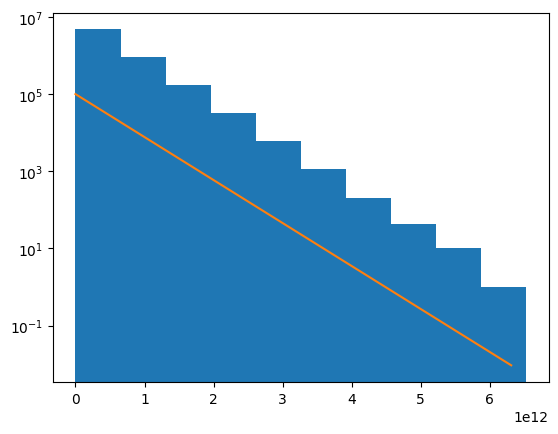

In [52]:
import matplotlib.pyplot as plt

# plt.hist(x, bins=1000, log=True)
print(f"{x.shape = }")
x_diff = np.diff(x)
print(f"{x_diff.shape = }")
plt.hist(x_diff, bins=10, log=True)

q = np.logspace(0, 12.8, 1000)
plt.plot(q, 1e5 * np.exp(-q / 3.9e11))

# plt.plot(x)
print(f"{max(x) = }")
print(f"{min(x) = }")
print(f"{max(x_diff) = }")
print(f"{min(x_diff) = }")


print()

In [ ]:
len(x_diff)

5878656

In [35]:
max(x_diff)

np.int64(6529083491397)

In [ ]:
len(x_diff.where(x_diff))

In [54]:
deltas: np.ndarray = np.diff(x)
reduced_deltas: np.ndarray = np.right_shift(deltas, 21)

np.savez_compressed("test.npz", shape=x.shape, first=x[0], deltas=reduced_deltas)

x_load = np.load("test.npz")
print(x_load)

NpzFile 'test.npz' with keys: shape, first, deltas
